In [1]:
%matplotlib inline

In [2]:
import numpy as np

from matplotlib import pyplot as plt


class TronBoard:
    EMPTY = 0 # Empty square. Can move here without issue
    PLAYER1_POSITION = 1  # Where player 1 is now
    PLAYER2_POSITION = 2  # Where player 2 is now
    VISITED1 = 3  # Visited by player 1
    VISITED2 = 4  # Visited by player 2
    VALID_VECTORS = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])  # Only valid vectors

    def __init__(self, n, m, p1, p2, v1, v2):
        """Creates a new tron board

        p1 is player 1 position (x, y), v1 is player 1 vector (1, 0), (0, 1) or their negations

        A board is described as the current position, the current state (empty,  p1, p2, visited1, visited2,)
        and the vector of the players.
        """
        assert p1 != p2

        # New board, with all zeros
        board = np.zeros((n, m))

        # Player 1 and 2 positions
        board[tuple(p1)] = TronBoard.PLAYER1_POSITION
        board[tuple(p2)] = TronBoard.PLAYER2_POSITION

        self.board = board
        
        self.gameover = False
        self.winner = None
        self.p1 = np.array(p1)
        self.p2 = np.array(p2)
        self.v1 = np.array(v1)
        self.v2 = np.array(v2)
        
    def valid_move(self, move):
        """Returns True if a player could move here. Doesn't account for other player's future actions!"""
        try:
            move = tuple(move)
            if move[0] < 0 or move[1] < 0:
                return False
            return self.board[move] == TronBoard.EMPTY
        except IndexError:
            return False
        
    
    def update(self, player1_move, player2_move):
        
        # If either move is None, then the previous move is used
        if player1_move is None:
            player1_move = self.v1
        if player2_move is None:
            player2_move = self.v2
            
        # Validate moves
        if player1_move not in TronBoard.VALID_VECTORS:
            raise ValueError("Player 1's move of {} is not valid".format(player1_move))
        if player2_move not in TronBoard.VALID_VECTORS:
            raise ValueError("Player 2's move of {} is not valid".format(player2_move))
            
        # Compute both player's new positions
        p1_new_position = self.p1 + player1_move
        p2_new_position = self.p2 + player2_move
        
        
        # If both players moved to same spot, both die
        if (p1_new_position == p2_new_position).all():
            self.gameover = True
            self.winner = None  # No winner
            return False  # no more to do
        
        # update board to show the previous player's positions as occupied
        self.board[tuple(self.p1)] = TronBoard.VISITED1
        self.board[tuple(self.p2)] = TronBoard.VISITED2
        
        p1_dead = False
        p2_dead = False
        
        
        # If either player moved to an occupied spot, they die
        # Otherwise, they occupy the new spot.
        if (not self.valid_move(p1_new_position)) or self.board[tuple(p1_new_position)] != TronBoard.EMPTY:
            p1_dead = True
        else:
            self.board[tuple(p1_new_position)] = TronBoard.PLAYER1_POSITION
            self.p1 = p1_new_position
        if (not self.valid_move(p2_new_position)) or self.board[tuple(p2_new_position)] != TronBoard.EMPTY:
            p2_dead = True
        else:
            self.board[tuple(p2_new_position)] = TronBoard.PLAYER2_POSITION
            self.p2 = p2_new_position
        
        # Check noone died
        if p1_dead:
            self.gameover = True
            if p2_dead:
                self.winner = None  # Both players died, no winner
            else:
                # Player 1 died, but player 2 survived
                self.winner = 2
        elif p2_dead:
            self.gameover = True
            self.winner = 1
        
        return not self.gameover
    
    def show(self):
        plt.imshow(self.board)
        plt.legend()

In [3]:
board = TronBoard(20, 20, (3, 4), (17, 4), (1, 0), (1, 0))

/home/rob/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


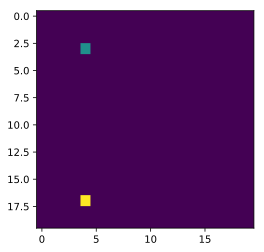

In [4]:
board.show()

In [5]:
import random

class SimpleBot:
    """Simple bot that chooses randomly from its valid moves"""
    
    def decide_move(self, board, player_position):
        valid_moves = [move for move in TronBoard.VALID_VECTORS
                       if board.valid_move(tuple(player_position + move))]
        if len(valid_moves):
            move = random.choice(valid_moves)
            #print("I moved {}".format(move))
            return move
        else:
            # Cannot make a move
            #print("I cannot move!")
            return None
        

In [6]:
from matplotlib import animation, rc

class TronGame:
    
    def __init__(self, board, bot1, bot2, show=True):
        self.board = board
        self.bot1 = bot1
        self.bot2 = bot2
        self.show = show
    
    def update(self):
        #print("Bot 1:")
        p1_move = self.bot1.decide_move(self.board, self.board.p1)
        #print("Bot 2: ")
        p2_move = self.bot2.decide_move(self.board, self.board.p2)
        self.board.update(p1_move, p2_move)
        if self.show:
            print("Bot 1: ", p1_move, self.board.p1)
            print("Bot 2: ", p2_move, self.board.p2)
            if self.board.gameover:
                print("Game over, winner is: {}".format(self.board.winner))
            self.board.show()
        return (self.board,)

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.board.gameover:
            raise StopIteration()
        self.update()
        return self

In [17]:
import random

def main():
    board = TronBoard(20, 20, (3, 4), (17, 4), (1, 0), (1, 0))
    bot1 = SimpleBot()
    bot2 = SimpleBot()
    game = TronGame(board, bot1, bot2, show=False)

    last_board = game.board.board

    def init():
        im.set_data(game.board.board)
        return (plot,)


    def animate(i):
        global last_board
        if game.board.gameover:
            data = last_board
        else:
            game.update()
            data = game.board.board
        im.set_array(data)
        last_board = data
        return (im,)

    fig = plt.figure()
    x, y = game.board.board.shape
    #ax = plt.axes(xlim=(0, x), ylim=(0, y))
    #line, = ax.plot([], [], lw=2)
    im=plt.imshow(game.board.board,interpolation='nearest')

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)

    return anim

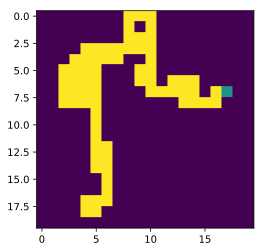

In [18]:
anim = main()
from IPython.display import HTML
HTML(anim.to_html5_video())